In [1]:
import sys
sys.path.append("..\\") # parent directory
from AQUA_general import AQUA
from batchAQUA_general import batchAQUA
from stimulus import *
from plotting_functions import *
from phase_response import *


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from functions import *

In [2]:
RS1 = {'name': 'RS', 'C': 100, 'k': 0.7, 'v_r': -60, 'v_t': -40, 'v_peak': 35,
    'a': 0.03, 'b': 40, 'c': -50, 'd': 100, 'e': 0., 'f': 0.0, 'tau': 0.0}

RS2 = {'name': 'RS', 'C': 100, 'k': 0.7, 'v_r': -60, 'v_t': -40, 'v_peak': 35,
    'a': 0.03, 'b': 40, 'c': -50, 'd': 100, 'e': 0.3, 'f': 200.0, 'tau': 0.0}

#FS1 = {'name': 'FS1', 'C': 20, 'k': 1, 'v_r': -55, 'v_t': -40, 'v_peak': 25,
#     'a': 0.2, 'b': -2, 'c': -45, 'd': 0, 'e': 0.0, 'f': 0.0, 'tau': 0.0}

#FS2 = {'name': 'FS2', 'C': 20, 'k': 1, 'v_r': -55, 'v_t': -40, 'v_peak': 25,
#     'a': 0.2, 'b': -2, 'c': -45, 'd': 0, 'e': 0.2, 'f': 200.0, 'tau': 0.0}

In [3]:
T = 2
dt = 0.01
N_iter = int(1000*T/dt)
print(N_iter)

# number of neurons
N_freq = 600
N_neurons = 2

# frequencies to sample
f_range = np.linspace(1, 200, N_freq)

threshold, x_ini = find_threshold(RS1, np.linspace(50, 400, 50))
print(threshold)
print(x_ini)

# Setup batch of neurons
param_arr = [RS1, RS2]

# Setup current pulses
N_pulses = 2
delay = 500 # ms
pulse_duration = 5  # ms
pulse1_end = delay + pulse_duration - dt # ms, from settings above

# minimum pulse height and the time between the end of the pulse and the spike.
pulse_height, time_to_spike = find_pulse_height(RS1, np.linspace(100, 1000, 100), threshold, x_ini, pulse_duration)  # pA
# describe ISI range relative to the time since the spike
ISI_range = np.linspace(time_to_spike + 5, 500, N_freq)
print(np.shape(ISI_range))

print(ISI_range)
I_inj = np.array([spikes_constant(N_iter, dt, threshold, isi, N_pulses, pulse_height, pulse_duration, delay) for isi in ISI_range for n in range(N_neurons)])
print(np.shape(I_inj))
N_sims = np.shape(I_inj)[0]


200000


100%|██████████| 49999/49999 [00:08<00:00, 6120.02it/s]


[242.85714286]
[-55.20454405 191.818238     0.        ]


100%|██████████| 49999/49999 [00:08<00:00, 5701.66it/s]


(600, 1)
[[ 21.09      ]
 [ 21.88951586]
 [ 22.68903172]
 [ 23.48854758]
 [ 24.28806344]
 [ 25.0875793 ]
 [ 25.88709516]
 [ 26.68661102]
 [ 27.48612688]
 [ 28.28564274]
 [ 29.0851586 ]
 [ 29.88467446]
 [ 30.68419032]
 [ 31.48370618]
 [ 32.28322204]
 [ 33.0827379 ]
 [ 33.88225376]
 [ 34.68176962]
 [ 35.48128548]
 [ 36.28080134]
 [ 37.0803172 ]
 [ 37.87983306]
 [ 38.67934891]
 [ 39.47886477]
 [ 40.27838063]
 [ 41.07789649]
 [ 41.87741235]
 [ 42.67692821]
 [ 43.47644407]
 [ 44.27595993]
 [ 45.07547579]
 [ 45.87499165]
 [ 46.67450751]
 [ 47.47402337]
 [ 48.27353923]
 [ 49.07305509]
 [ 49.87257095]
 [ 50.67208681]
 [ 51.47160267]
 [ 52.27111853]
 [ 53.07063439]
 [ 53.87015025]
 [ 54.66966611]
 [ 55.46918197]
 [ 56.26869783]
 [ 57.06821369]
 [ 57.86772955]
 [ 58.66724541]
 [ 59.46676127]
 [ 60.26627713]
 [ 61.06579299]
 [ 61.86530885]
 [ 62.66482471]
 [ 63.46434057]
 [ 64.26385643]
 [ 65.06337229]
 [ 65.86288815]
 [ 66.66240401]
 [ 67.46191987]
 [ 68.26143573]
 [ 69.06095159]
 [ 69.86046745]

In [4]:
# define batch now that we know how many simulations are run
batch_params = []
for i in range(N_freq):
    batch_params += param_arr
print(len(batch_params))
x_start = np.full((N_sims, 3), fill_value = x_ini)
t_start = np.zeros(N_sims)
# define and initialize
batch = batchAQUA(batch_params)
batch.Initialise(x_start, t_start)

# Run simulation
X, T, spikes = batch.update_batch(dt, N_iter, I_inj)

1200


100%|██████████| 199999/199999 [01:34<00:00, 2112.95it/s]


In [6]:
pulse2_start = np.zeros(N_sims)
spike_boolean = np.zeros(N_sims)

for n in range(N_sims):
    if len(spikes[n, np.isnan(spikes[n])]) != 1:        # if 2 spikes generated
        spike_boolean[n] = 1
    pulse_times = np.argwhere(I_inj[n, :] >= threshold + 1) * dt  # pulse times in ms
    pulse2_start[n] = pulse_times[np.where(pulse_times > pulse1_end)][0] # start time of the second pulse, ms

InterPulse_Intervals = pulse2_start - pulse1_end
first_spike_time = pulse1_end + time_to_spike

resonant_ISI = np.reshape(pulse2_start - first_spike_time, shape = (N_neurons, N_freq), order = 'F')
resonant_f = 1000/resonant_ISI

print(np.shape(resonant_ISI))
print(np.shape(resonant_f))

# resonant_ISI only stores the pulse times relative to the first spike.

bands = np.reshape(spike_boolean, shape = (N_neurons, N_freq), order = 'F')

print(np.shape(bands))

resonance_bands_base_neuron = get_resonance_bands(resonant_f[0, :], bands[0, :])
print(resonance_bands_base_neuron)
largest_band_idx = np.argmax(np.diff(resonance_bands_base_neuron, axis = 1))
print(resonance_bands_base_neuron[largest_band_idx])

print(np.mean(resonance_bands_base_neuron[largest_band_idx]))

#plt.plot(resonant_f[0], bands[0], label = param_arr[0]['name'])
#plt.plot(resonant_f[1], bands[1], label = param_arr[1]['name'])
#plt.xlim((0, 100))
#plt.legend()
#plt.show()



(2, 600)
(2, 600)
(2, 600)
[[15.25087693 29.0866783 ]]
[15.25087693 29.0866783 ]
22.1687776133941


In [ ]:
def plot_resonance_map(frequencies, bands):
    """
    Returns a heat map of the resonance frequencies of the neurons

    IN:
        frequencies:    array (N_neurons, N_frequencies)
                        list of frequencies tested

        bands:          ndarray (N_neurons, N_frequencies)
                        resonance bands for each neuron
    
    """

    fig, ax = plt.subplots(1, 1, figsize = (8, 8))

    ax.imshow(bands, origin = 'lower', cmap = 'Greys')

    ax.set_xlabel('Frequency (Hz)', fontsize = 16)
    ax.set_ylabel('Neuron index', fontsize = 16)

    ax.set_title('Resonance Map of neurons', fontsize = 20)

    return fig, ax

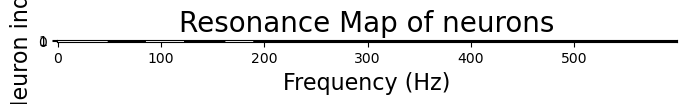

In [ ]:
fig, ax = plot_resonance_map(resonant_f, bands)
plt.show()

(11, 10)
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.]
 [ 3.  3.  3.  3.  3.  3.  3.  3.  3.  3.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.]
 [ 5.  5.  5.  5.  5.  5.  5.  5.  5.  5.]
 [ 6.  6.  6.  6.  6.  6.  6.  6.  6.  6.]
 [ 7.  7.  7.  7.  7.  7.  7.  7.  7.  7.]
 [ 8.  8.  8.  8.  8.  8.  8.  8.  8.  8.]
 [ 9.  9.  9.  9.  9.  9.  9.  9.  9.  9.]
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]]
